# Example notebook

This notebook demonstrates the analysis and visualization of sound data that was done in order to model the impact of trucks on noise pollution in Red Hook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import datetime 
from datetime import timedelta
import pytz
from pytz import timezone
from numpy import load
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import h5py
import pylab
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import librosa
import matplotlib.dates as md
import sys

In [2]:
sys.path.insert(1, '../modules')
import data
import display

Loading the hdf5 files

In [3]:
h5 = h5py.File('../data/sound_data_improved.hdf5', 'r')

In [4]:
d = h5['sound_data']

# Creating subsample of 10000 points from all four sensors

In [5]:
sample_nums = np.random.choice(range(d.shape[0]), 10000, replace = False)

In [6]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

# Reading and graphing data from one sensor

Reading June data from one of the sensors

In [7]:
df = pd.read_csv("../data/sonycnode-b827ebc178d2.sonyc.csv", skiprows = 2, low_memory = False)
df.head()

,timestamp,dBAS
0,1.559362e+09,63.53
1,1.559362e+09,63.73
2,1.559362e+09,64.94
3,1.559362e+09,63.09
4,1.559362e+09,61.66


Creating two numpy array with the timestamps for June and the corresponding SPL values for June

In [8]:
time_arr = np.empty(df.shape[0], dtype = datetime.datetime)
timestamp_arr = df['timestamp'].values
dBAS_arr = df['dBAS'].values

In [9]:
time_arr = [data.convert_timestamps(x) for x in timestamp_arr]

Creating a new dataframe with timestamps in datetime format

In [10]:
time_df = df
time_df['timestamp'] = time_arr
time_df.tail()

,timestamp,dBAS
2589895,2019-07-01 00:00:38.810000-04:00,66.04
2589896,2019-07-01 00:00:39.810000-04:00,69.75
2589897,2019-07-01 00:00:40.810000-04:00,68.68
2589898,2019-07-01 00:00:41.810000-04:00,73.17
2589899,2019-07-01 00:00:42.810000-04:00,77.04


# Clustering on 45 dimensions

Running PCA on the embeddings in order to reduce dimensionality to 45

In [11]:
pca_45 = sklearnPCA(45)
projected_45 = pca_45.fit_transform(d['feature_vector'])

In [12]:
b827ebc178d2_mask = data.get_sensor_mask(d['sensor_id'], b'sonycnode-b827ebc178d2.sonyc')
b827ebc178d2_transformed = projected_45[b827ebc178d2_mask]
b827ebc178d2_timestamps = d[b827ebc178d2_mask, 'timestamp']
b827ebc178d2_timestamps_dt = [data.convert_timestamps(x) for x in b827ebc178d2_timestamps]

# Dataframe with timestamps and cluster assignment

In [13]:
truck_clusters = [5, 10, 11, 18, 20, 37, 42, 57, 63]

Dataframe spanning over the whole month


In [14]:
all_cluster_assignments = data.get_cluster_assignments(64, b827ebc178d2_transformed, projected_45[index])
seconds_b827ebc178d2_timestamps_dt = [x.replace(microsecond=0) for x in b827ebc178d2_timestamps_dt]

In [15]:
assignments_df = pd.DataFrame(data={'assignment':all_cluster_assignments}, \
                              index = seconds_b827ebc178d2_timestamps_dt)
assignments_df.head()

,assignment
2019-06-01 00:00:16-04:00,2
2019-06-01 00:00:17-04:00,60
2019-06-01 00:00:18-04:00,60
2019-06-01 00:00:19-04:00,42
2019-06-01 00:00:20-04:00,60


Removed all duplicate entries in dataframe

In [16]:
removed_assignments_df = assignments_df[~assignments_df.index.duplicated()]

In [17]:
complete = pd.date_range(datetime.datetime(2019, 6, 1, 4), datetime.datetime(2019, 7, 1, 4), periods=3600*24*30)
seconds_complete = [x.replace(microsecond=0, nanosecond=0) for x in complete]
aware_seconds_complete = [pytz.utc.localize(x) for x in seconds_complete]
tz_seconds_complete = [x.astimezone(pytz.timezone('US/Eastern')) for x in aware_seconds_complete]

Replaces actual cluster assignment with 0 for no assignment value, 1 for a truck cluster, 2 for every other cluster

In [18]:
complete_assignments_df = removed_assignments_df.reindex(tz_seconds_complete, axis='index', fill_value = 0)

In [19]:
complete_assignments_df = complete_assignments_df.replace(truck_clusters, 1)
complete_assignments_df = complete_assignments_df.replace(range(2,64), 2)

In [20]:
complete_assignments_df.head()

,assignment
2019-06-01 00:00:00-04:00,0
2019-06-01 00:00:01-04:00,0
2019-06-01 00:00:02-04:00,0
2019-06-01 00:00:03-04:00,0
2019-06-01 00:00:04-04:00,0


In [21]:
complete_assignments_df.tail()

,assignment
2019-06-30 23:59:55-04:00,2
2019-06-30 23:59:56-04:00,0
2019-06-30 23:59:57-04:00,0
2019-06-30 23:59:58-04:00,0
2019-07-01 00:00:00-04:00,0


# Dataframe with timestamp and SPL value

In [22]:
time_df.head()

,timestamp,dBAS
0,2019-06-01 00:00:42.690000-04:00,63.53
1,2019-06-01 00:00:43.690000-04:00,63.73
2,2019-06-01 00:00:44.690000-04:00,64.94
3,2019-06-01 00:00:45.690000-04:00,63.09
4,2019-06-01 00:00:46.690000-04:00,61.66


In [23]:
naive_time_df = [x.replace(tzinfo=None) for x in time_df['timestamp']]

In [24]:
seconds_complete_timestamp = [x.replace(microsecond=0) for x in time_df['timestamp']]

In [25]:
spl_df = pd.DataFrame(data={'dBAS': dBAS_arr}, index=seconds_complete_timestamp)

In [26]:
spl_df.tail()

,dBAS
2019-07-01 00:00:38-04:00,66.04
2019-07-01 00:00:39-04:00,69.75
2019-07-01 00:00:40-04:00,68.68
2019-07-01 00:00:41-04:00,73.17
2019-07-01 00:00:42-04:00,77.04


# Joining cluster assignment dataframe and SPL dataframe

This dataframe is for the whole month, so if you slice it based on date, it will give you different subsets of information. There is no need to recreate any dataframes.

In [27]:
all_joined_df = spl_df.join(complete_assignments_df)

In [28]:
all_joined_df.loc[pd.isnull(all_joined_df['assignment']), 'assignment'] = 0

Gets rid of the extra 42 seconds of data in July 1st

In [29]:
all_joined_df_cut = all_joined_df[:-42]

In [30]:
all_joined_df_cut.head()

,dBAS,assignment
2019-06-01 00:00:42-04:00,63.53,2.0
2019-06-01 00:00:43-04:00,63.73,1.0
2019-06-01 00:00:44-04:00,64.94,2.0
2019-06-01 00:00:45-04:00,63.09,0.0
2019-06-01 00:00:46-04:00,61.66,2.0


# Creating matrix of SPL values over each day

Matrix of time and day, containing SPL values for every second of every day (only weekdays)

In [31]:
spl_complete = spl_df['dBAS']

In [32]:
beginning_spl_indices = \
pd.date_range(datetime.datetime(2019, 6, 1, 4, 0, 0), datetime.datetime(2019, 6, 1, 4, 0, 42), periods=42)
beginning_spl_indices = [x.replace(microsecond=0, nanosecond=0) for x in beginning_spl_indices]
beginning_spl_indices = [pytz.utc.localize(x) for x in beginning_spl_indices]
beginning_spl_indices = [x.astimezone(pytz.timezone('US/Eastern')) for x in beginning_spl_indices]

In [33]:
beginning_spl = pd.Series(np.nan, index=beginning_spl_indices)

In [34]:
spl_complete_2 = pd.concat([beginning_spl, spl_complete])

In [35]:
spl_complete_month = spl_complete_2[:-43]

# Creating median array for weekends

Creating arrays of SPL collected on weekdays and weekends

In [36]:
spl_complete_month_weekends = spl_complete_month[spl_complete_month.index.dayofweek >= 5]

In [37]:
spl_complete_month_weekdays = spl_complete_month[spl_complete_month.index.dayofweek < 5]

Removing duplicate times from both arrays

In [38]:
spl_complete_month_weekends = spl_complete_month_weekends[~spl_complete_month_weekends.index.duplicated()]

In [39]:
spl_complete_month_weekdays = spl_complete_month_weekdays[~spl_complete_month_weekdays.index.duplicated()]

Getting median values for weekends and weekdays

In [40]:
weekend_medians = data.get_median(spl_complete_month_weekends)

[ 1  2  8  9 15 16 22 23 29 30]
1: 86337
2: 86338
8: 86335
9: 86201
15: 86335
16: 86338
22: 86335
23: 86244
29: 86335
30: 86340


../modules/data.py:214: RuntimeWarning: invalid value encountered in less
  complete_day_arr[complete_day_arr<1] = np.nan


In [41]:
weekday_medians = data.get_median(spl_complete_month_weekdays)

[ 3  4  5  6  7 10 11 12 13 14 17 18 19 20 21 24 25 26 27 28]
3: 86340
4: 86338
5: 86339
6: 86333
7: 86341
10: 86361
11: 86337
12: 86325
13: 86349
14: 86338
17: 86338
18: 86337
19: 86339
20: 86341
21: 86336
24: 86316
25: 86338
26: 86087
27: 86218
28: 86356


Adding the first 42 seconds of June that didn't get included in the measured SPL data

In [42]:
beginning_spl_indices_series = pd.Series(data=beginning_spl_indices)

Creating datetime indices spanning the whole month, with the additional 42 secs in the beginning of June

In [43]:
medians_df_index = pd.concat([beginning_spl_indices_series[0:42], all_joined_df.reset_index()['index']])

Filling an array that spans the whole month, then filling it with median values for one day that are repeated

In [44]:
month_weekday_median = np.empty(len(medians_df_index))

In [45]:
for i in range(len(medians_df_index)):
    month_weekday_median[i] = weekday_medians[i%len(weekday_medians)]

# Making dataframes with median values for the month

Creating dataframe with weekday medians for whole month

In [46]:
weekday_medians_df = pd.DataFrame({'median_dBAS':month_weekday_median}, index=medians_df_index)

In [47]:
weekday_medians_df.tail()

,median_dBAS
2019-07-01 00:00:38-04:00,61.100
2019-07-01 00:00:39-04:00,61.420
2019-07-01 00:00:40-04:00,62.440
2019-07-01 00:00:41-04:00,60.525
2019-07-01 00:00:42-04:00,62.255


In [48]:
weekend_medians_df_indices = weekday_medians_df.loc[weekday_medians_df.index.dayofweek>=5].index

In [49]:
weekend_medians_df_values = np.empty(len(weekend_medians_df_indices))

Replacing weekday values in weekend times with the weekend median SPL

In [50]:
for x in range(len(weekend_medians_df_values)):
    weekend_medians_df_values[x] = weekend_medians[x % len(weekend_medians)]

In [51]:
weekend_medians_df_values

array([61.01, 63.16, 64.48, ..., 59.41, 58.84, 58.08])

Making a dataframe with weekend medians

In [52]:
weekend_medians_df = pd.DataFrame({'median_dBAS':weekend_medians_df_values}, index=weekend_medians_df_indices)

In [53]:
weekend_medians_df = weekend_medians_df[~weekend_medians_df.index.duplicated()]

In [54]:
weekend_medians_df.tail()

,median_dBAS
2019-06-30 23:59:55-04:00,58.480
2019-06-30 23:59:56-04:00,59.075
2019-06-30 23:59:57-04:00,59.410
2019-06-30 23:59:58-04:00,58.840
2019-06-30 23:59:59-04:00,58.080


# Replacing weekend values in dataframe with correct values

Merging dataframe with weekday median values and dataframe with weekend median values. The dataframe with weekday median values has indices for the whole month. Indices that are on the weekend will be replaced with the weekend median values.

In [55]:
both_medians_df = weekday_medians_df.merge(weekend_medians_df, how='outer', left_index=True, right_index=True)

median_dBAS_x is the weekday median values, median_dBAS_y is the weekend median values. Since this is an outer join, many values in median_dBAS_y will be NaN.

In [56]:
both_medians_df.head()

,median_dBAS_x,median_dBAS_y
2019-06-01 00:00:00-04:00,57.755,61.01
2019-06-01 00:00:01-04:00,58.220,63.16
2019-06-01 00:00:02-04:00,57.980,64.48
2019-06-01 00:00:03-04:00,58.360,63.70
2019-06-01 00:00:04-04:00,58.730,63.76


Creates a new column that replaces weekday median values that are in the weekend index with the weekend median values.

In [57]:
both_medians_df['median_dBAS'] = \
both_medians_df['median_dBAS_x'].where(both_medians_df['median_dBAS_y'].isnull(), \
                                                                              both_medians_df['median_dBAS_y'])

Example: 

In [58]:
both_medians_df.loc['2019-06-28 23:00:33-04:00']

median_dBAS_x    67.365
median_dBAS_y       NaN
median_dBAS      67.365
Name: 2019-06-28 23:00:33-04:00, dtype: float64

Gets rid of the columns with weekday and weekend median values, since we have a column with the correct median values for both weekdays and weekends.

In [59]:
both_medians_df = both_medians_df.drop(['median_dBAS_x', 'median_dBAS_y'], axis=1)

In [60]:
both_medians_df.head()

,median_dBAS
2019-06-01 00:00:00-04:00,61.01
2019-06-01 00:00:01-04:00,63.16
2019-06-01 00:00:02-04:00,64.48
2019-06-01 00:00:03-04:00,63.70
2019-06-01 00:00:04-04:00,63.76


# Joining weekday and weekend medians to dataframe

Joining the median dataframe to the dataframe with SPL and cluster assignment

In [61]:
all_joined_df_cut_median = all_joined_df_cut.join(both_medians_df)

In [62]:
all_joined_df_cut_median.loc['2019-06-29 23:00:33-04:00']

,dBAS,assignment,median_dBAS
2019-06-29 23:00:33-04:00,65.27,1.0,61.59
2019-06-29 23:00:33-04:00,65.27,1.0,61.59
2019-06-29 23:00:33-04:00,71.26,1.0,61.59
2019-06-29 23:00:33-04:00,71.26,1.0,61.59


In [63]:
removed_all_joined_df_cut_median = all_joined_df_cut_median[~all_joined_df_cut_median.index.duplicated()]

# Example Plots

Plots SPL level in green, the shaded parts correspond to audio that is grouped into trucks (red) and non-trucks (gray). SPL peaks are plotted with dots in the same color scheme.

/home/cusp/meh708/.conda/envs/redhook_analysis_storage/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


300    2019-06-03 14:05:00-04:00
594    2019-06-03 14:09:54-04:00
674    2019-06-03 14:11:14-04:00
800    2019-06-03 14:13:20-04:00
1740   2019-06-03 14:29:00-04:00
2372   2019-06-03 14:39:32-04:00
2395   2019-06-03 14:39:55-04:00
3069   2019-06-03 14:51:09-04:00
3273   2019-06-03 14:54:33-04:00
3373   2019-06-03 14:56:13-04:00
3580   2019-06-03 14:59:40-04:00
Name: index, dtype: datetime64[ns, US/Eastern]
300     75.38
594     75.07
674     71.32
800     75.05
1740    82.17
2372    79.24
2395    80.27
3069    70.03
3273    69.99
3373    78.27
3580    73.52
Name: dBAS, dtype: float64
241


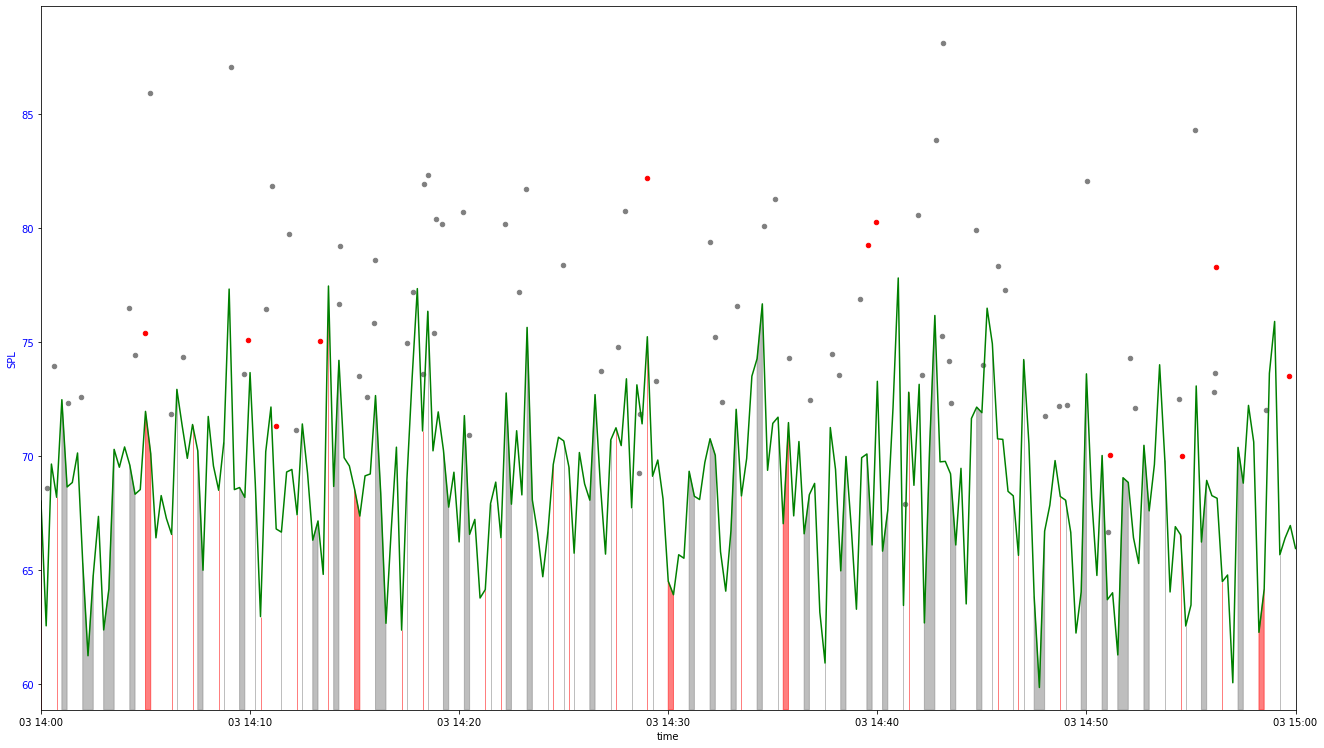

In [64]:
display.plot_truck_clusters_first(all_joined_df_cut['2019-06-03 14:00:00-04:00':'2019-06-03 15:0:00-04:00'], \
                            7, 11, 15, 'mean').show()

Plots SPL level in green, the shaded parts correspond to audio that is grouped into trucks (red) and non-trucks (gray). SPL peaks are plotted with dots in the same color scheme. The median SPL over the specificed time period is plotted in blue.

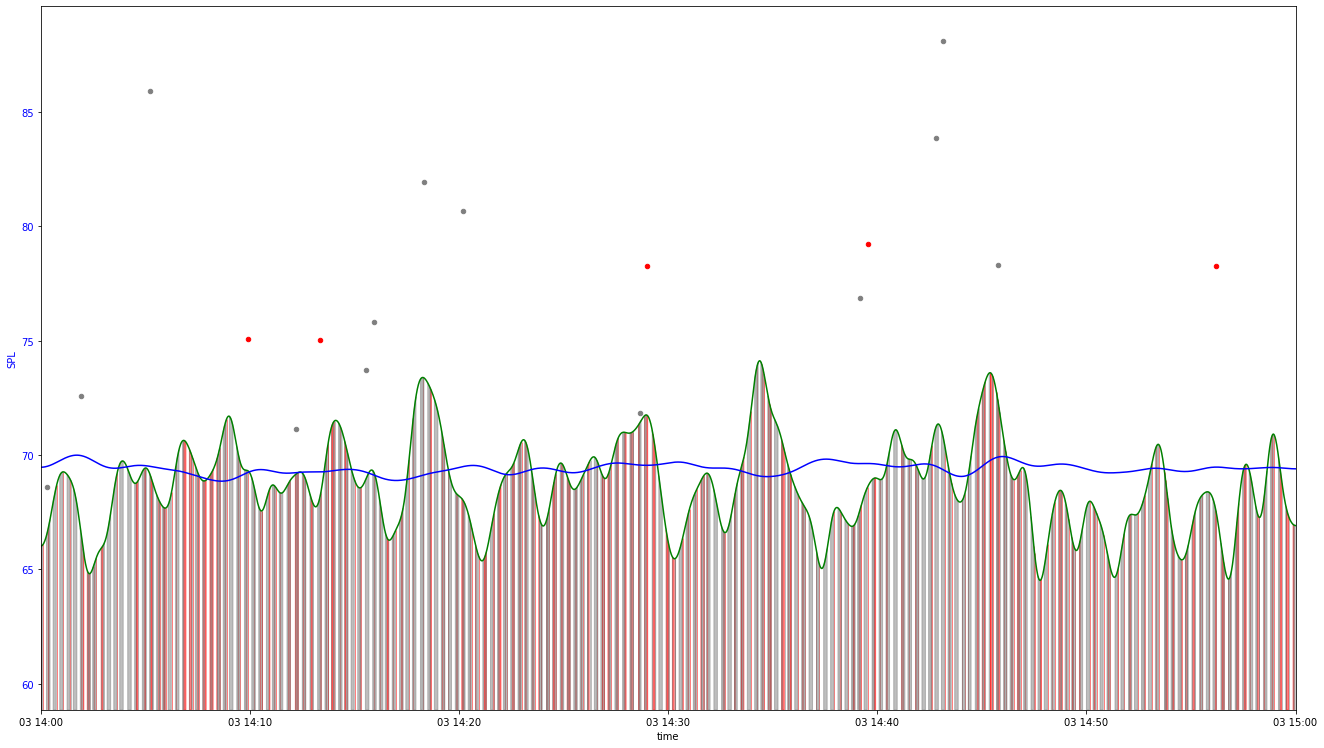

In [65]:
display.plot_truck_clusters_median(all_joined_df_cut_median['2019-06-03 14:00:00-04:00':'2019-06-03 15:00:00-04:00'], \
                            3, 20, 50, 1, 'gaussian').show()

Plots SPL level in green, the shaded parts correspond to audio that is grouped into trucks (red) and non-trucks (gray). SPL peaks are plotted with dots in the same color scheme. The median SPL over the specificed time period is plotted in blue. There is only shading when the actual SPL is greater than the median SPL.

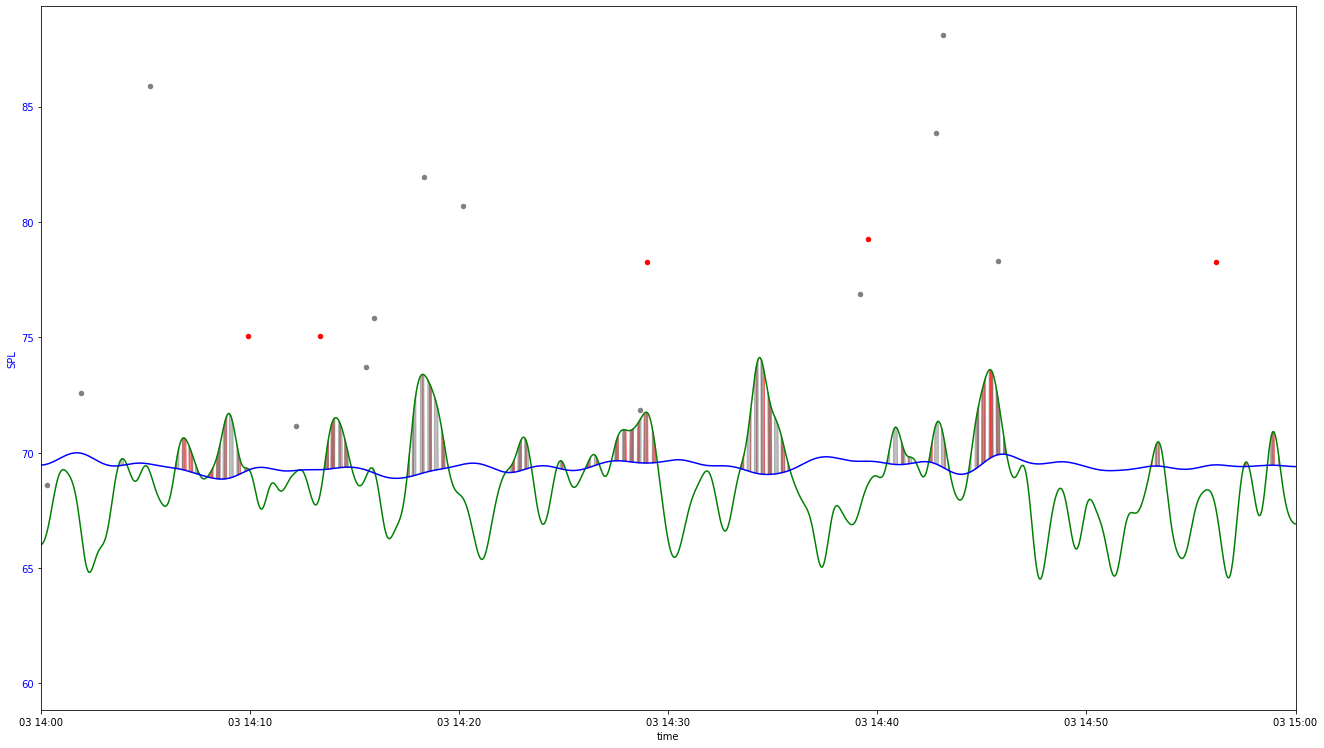

In [66]:
display.plot_truck_clusters_median_shading(all_joined_df_cut_median['2019-06-03 14:00:00-04:00':'2019-06-03 15:00:00-04:00'], \
                            3, 20, 50, 1, 'gaussian').show()

Plots SPL level in green, the shaded parts correspond to audio that is grouped into trucks (red) and non-trucks (gray). SPL peaks are plotted with dots in the same color scheme. The median SPL over the specificed time period is plotted in blue. There is only shading when the actual SPL is greater than the median SPL. This figure is tailored to present to an audience.

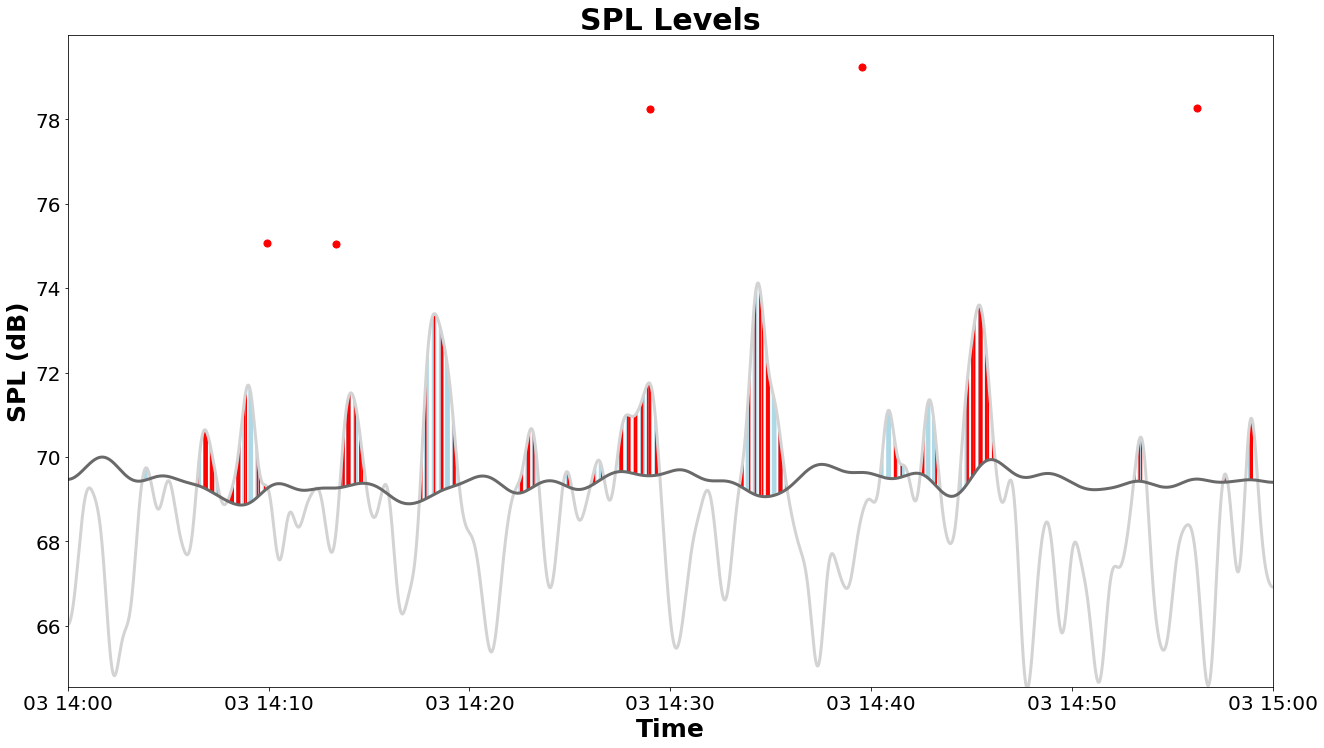

In [67]:
display.plot_truck_clusters_final(all_joined_df_cut_median['2019-06-03 14:00:00-04:00':'2019-06-03 15:00:00-04:00'], \
                            3, 20, 50, 1, 'gaussian').show()

Plots the SPL normalized to the median SPL (in other words, the difference between the actual SPL and the median SPL). The SPL level is in green, the shaded parts correspond to audio that is grouped into trucks (red) and non-trucks (gray). SPL peaks are plotted with dots in the same color scheme.

594    2019-06-03 14:09:54-04:00
800    2019-06-03 14:13:20-04:00
1739   2019-06-03 14:28:59-04:00
2372   2019-06-03 14:39:32-04:00
3373   2019-06-03 14:56:13-04:00
Name: index, dtype: datetime64[ns, US/Eastern]
594     75.07
800     75.05
1739    78.26
2372    79.24
3373    78.27
Name: dBAS, dtype: float64


/home/cusp/meh708/.conda/envs/redhook_analysis_storage/lib/python3.7/site-packages/pandas/core/common.py:232: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  result = np.asarray(values, dtype=dtype)


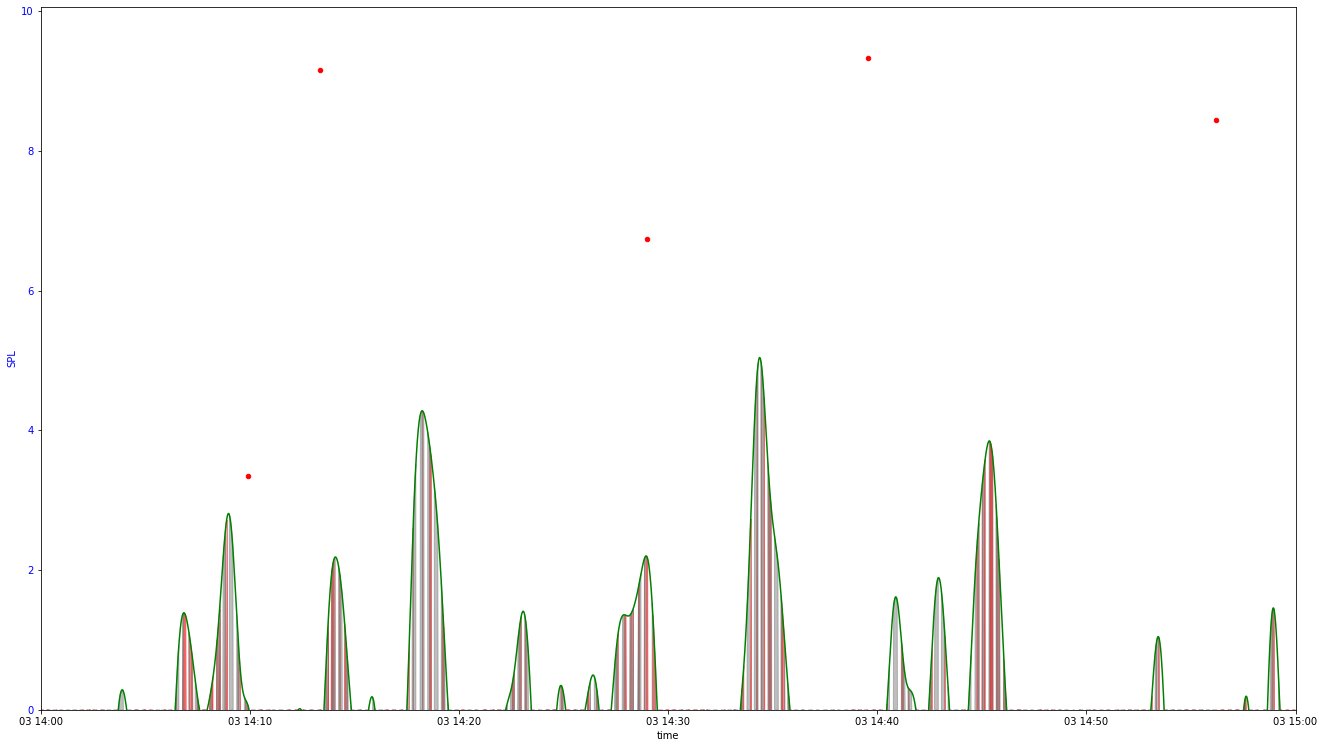

In [68]:
display.plot_truck_clusters_normalized(all_joined_df_cut_median['2019-06-03 14:00:00-04:00':'2019-06-03 15:00:00-04:00'], \
                            3, 20, 50, 1, 'gaussian').show()

Plots the SPL normalized to the median SPL (in other words, the difference between the actual SPL and the median SPL), but only when the sound at that second corresponds to a truck as determined by the clustering.

5


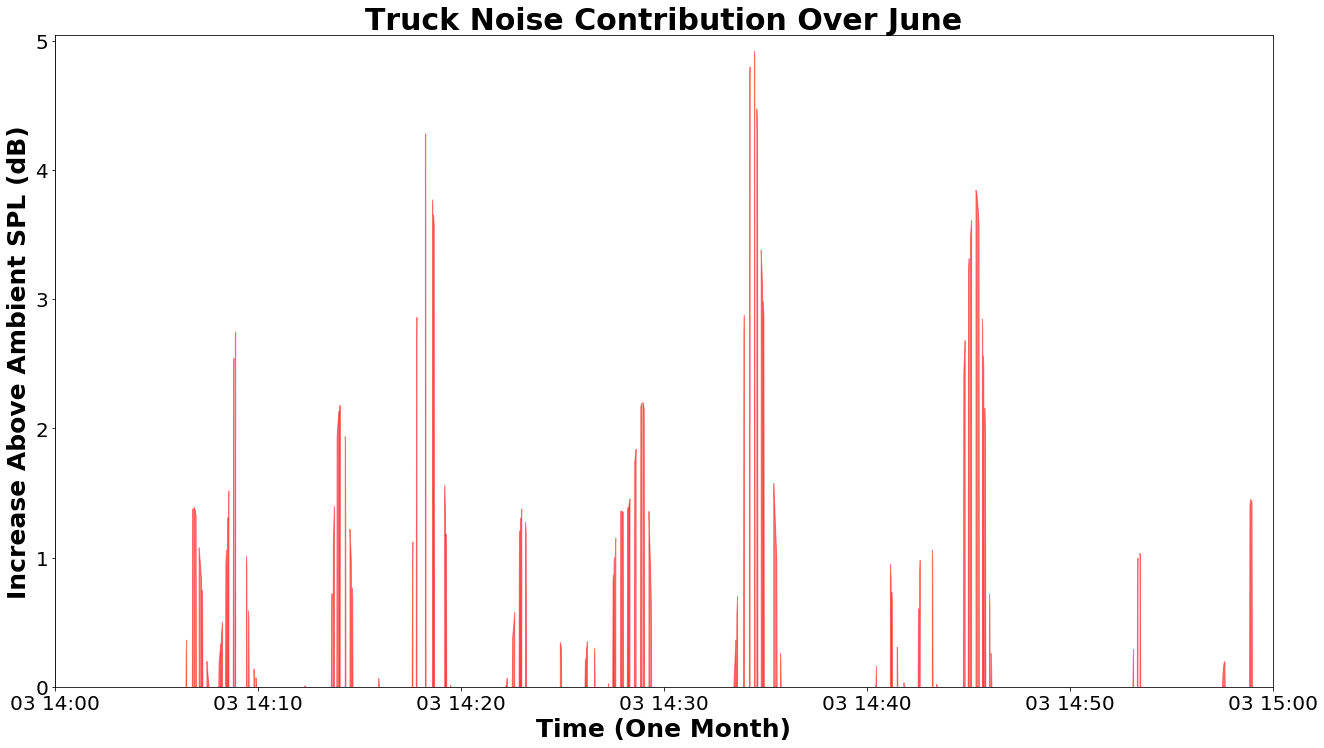

In [69]:
display.plot_truck_clusters_normalized_final(all_joined_df_cut_median['2019-06-03 14:00:00-04:00':'2019-06-03 15:00:00-04:00'], \
                            3, 20, 50, 1, 'gaussian').show()